<a href="https://colab.research.google.com/github/asanneh/CS109B_Final_Project_Group_35/blob/master/CS109B_Final_Project_Group_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div align="center">COMPSCI 109B Final Project - Group 35</div>

# <div align="center"> Project: Measuring the Shape and Brightness of Galaxies with Neural Networks</div>

# <div align='center'> Alpha Sanneh, Brian Tao, Grace Greason, Evan Arnold</div>

## **Data Preprocessing**

In [0]:
#install libraries we need here
# !pip install tf_keras_vis
## Please NOTE: you have to install the three libraries below in order to get pymc3 working
# !pip install arviz==0.6.1
# !pip install pymc3==3.8
# !pip install Theano==1.0.4

In [2]:
#import relevant libraries
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os
import datetime
import h5py
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from scipy.stats import norm
import matplotlib as mpl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Change working directory to where the files needed for the project are stored
file_path = '/content/drive/My Drive/Data'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

FileNotFoundError: ignored

In [0]:
# Read data
f=h5py.File('Data.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

In [0]:
# Get the shape of images with noise and images without noise
image_withnoise.shape, image_nonoise.shape

((18779, 64, 64), (18779, 64, 64))

## **Visualizing images**

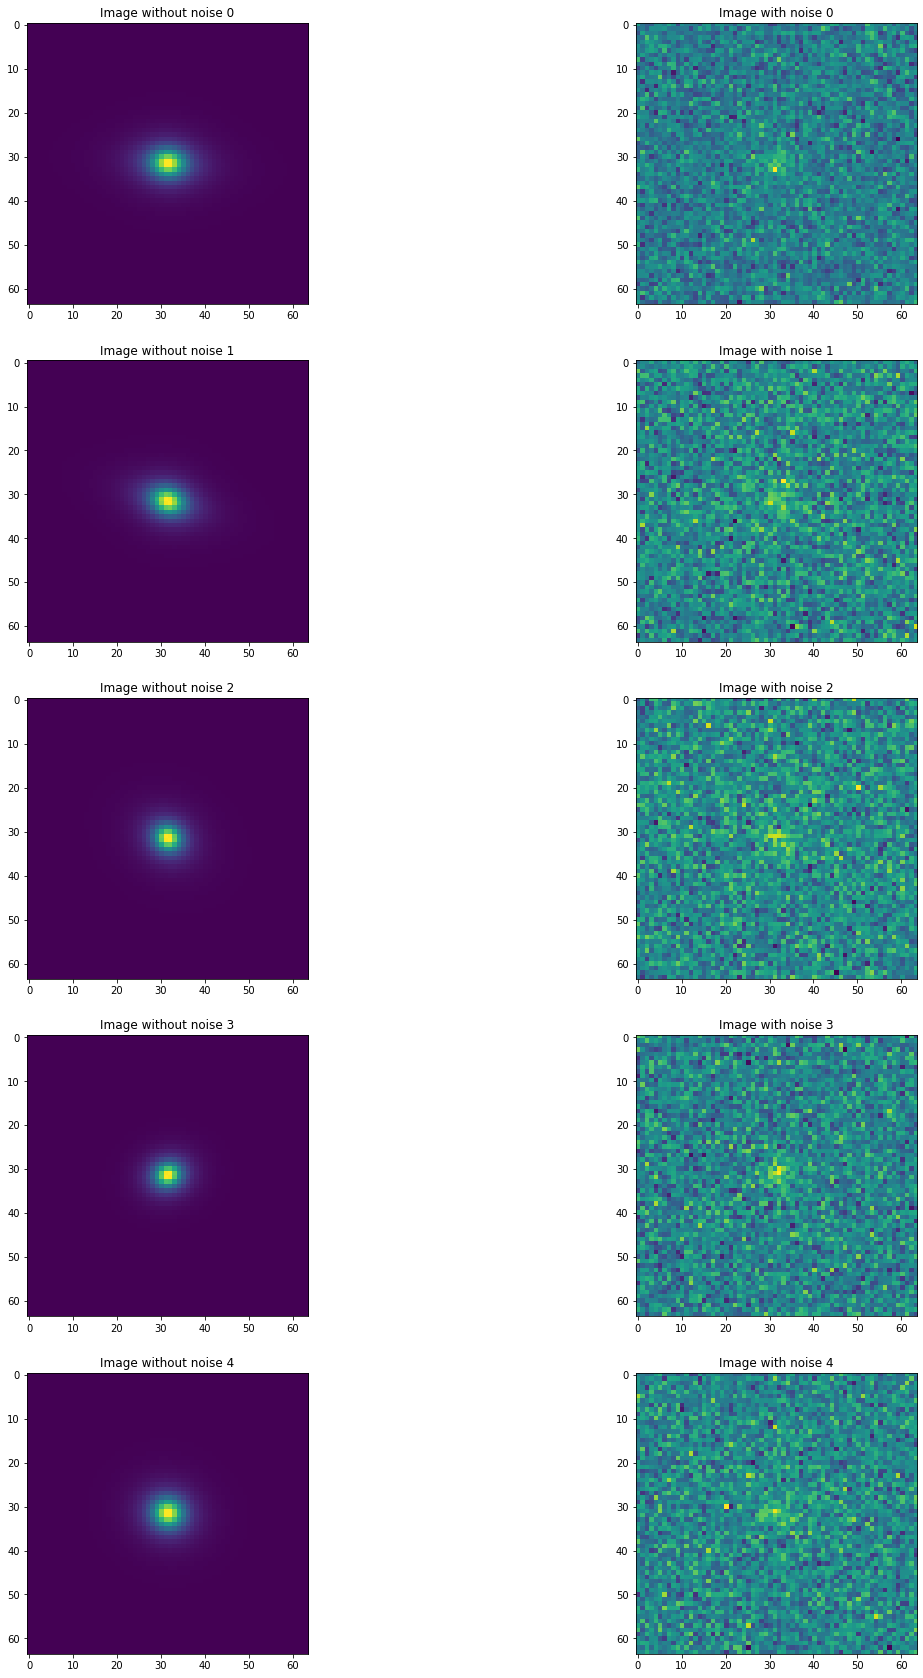

In [0]:
# Plot first five images without noise and with noise
fig, ax = plt.subplots(5,2, figsize=(20,30))
for i in range(5):
    ax[i][0].imshow(image_nonoise[i])
    ax[i][0].set_title('Image without noise {}'.format(i))
    ax[i][1].imshow(image_withnoise[i])
    ax[i][1].set_title('Image with noise {}'.format(i))

## **Inspecting Noise** 

Below we plot the histogram of the noise of the dataset along with the best fit normal distribution. We do so to verify that the noise is indeed Gaussian. This will inform our model design. Specifically, it will allow us to model the noise in order to better predict the response.

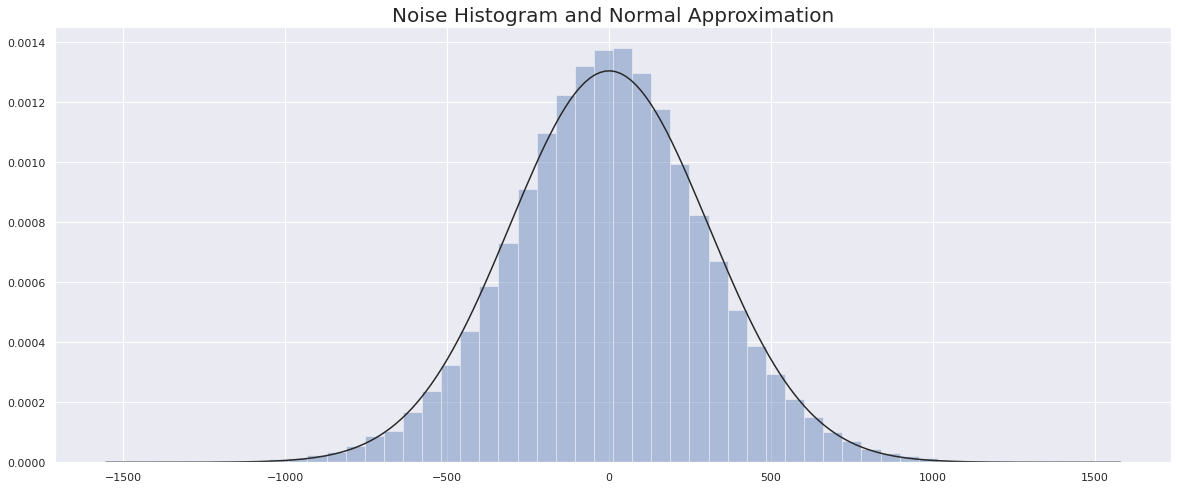

In [0]:

# distribution of noise (first n pixels for efficiency)
sns.set()
n = 100000
# noise
noise = image_withnoise - image_nonoise
noise = noise.reshape(-1, 1)
# plot
fig, ax = plt.subplots(figsize=(20,8))
sns.distplot(noise[1:n], fit=norm, kde=False, ax=ax)
ax.set_title('Noise Histogram and Normal Approximation', fontsize=20);

## **Inspecting the Correlations of the Label Parameters**

As shown below, the response variables have no significant correlation aside from g1 and g2. We expect the scatters of circles as both g1 and g2 are functions of the same variables using different sinusoid functions (cos vs. sin). Care should be taken when modeling g1 and g2 as their outcome is highly correlated (though in a non-linear fashion).

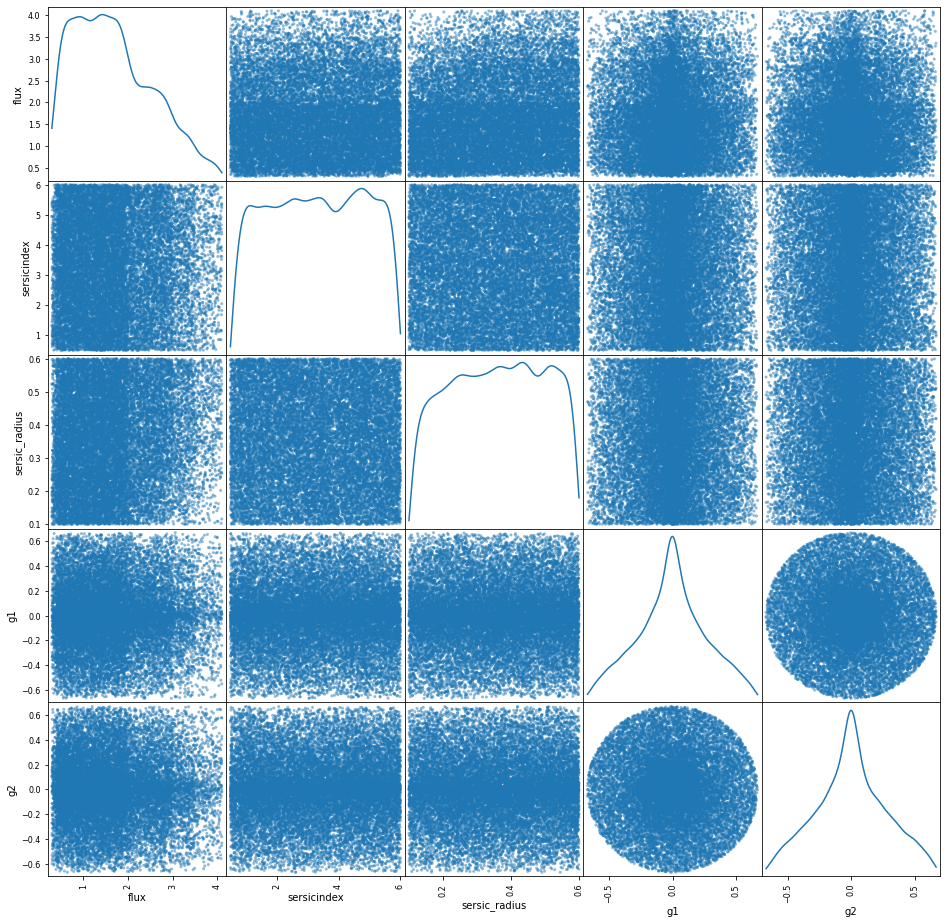

In [0]:
# convert response 2D array to labeled dataframe
label_df = pd.DataFrame(label, columns=['flux', 'sersic' 'index', 'sersic_radius', 'g1', 'g2'])
# scatter matrix of response
pd.plotting.scatter_matrix(label_df, figsize=(16, 16), diagonal='kde');

In [0]:
print(f'Image with noise max: {image_withnoise[0].max()}')
print(f'Image with noise min: {image_withnoise[0].min()}')
print(f'Image with no noise max: {image_nonoise[0].max()}')
print(f'Image with no noise min: {image_nonoise[0].min()}')

Image with noise max: 1088.6094996083598
Image with noise min: -799.6288667294024
Image with no noise max: 455.3077087402344
Image with no noise min: 0.03963421285152435


## **Inspecting the Distributions of the Label Parameters**

We expect Sérsic index and Sérsic radius to be uniformly distributed because they are each randomly generated from a uniform distribution. 

g1 and g2 have the same distribution (and are therefore highly correlated) because they are calcuated using the same mathematical function.


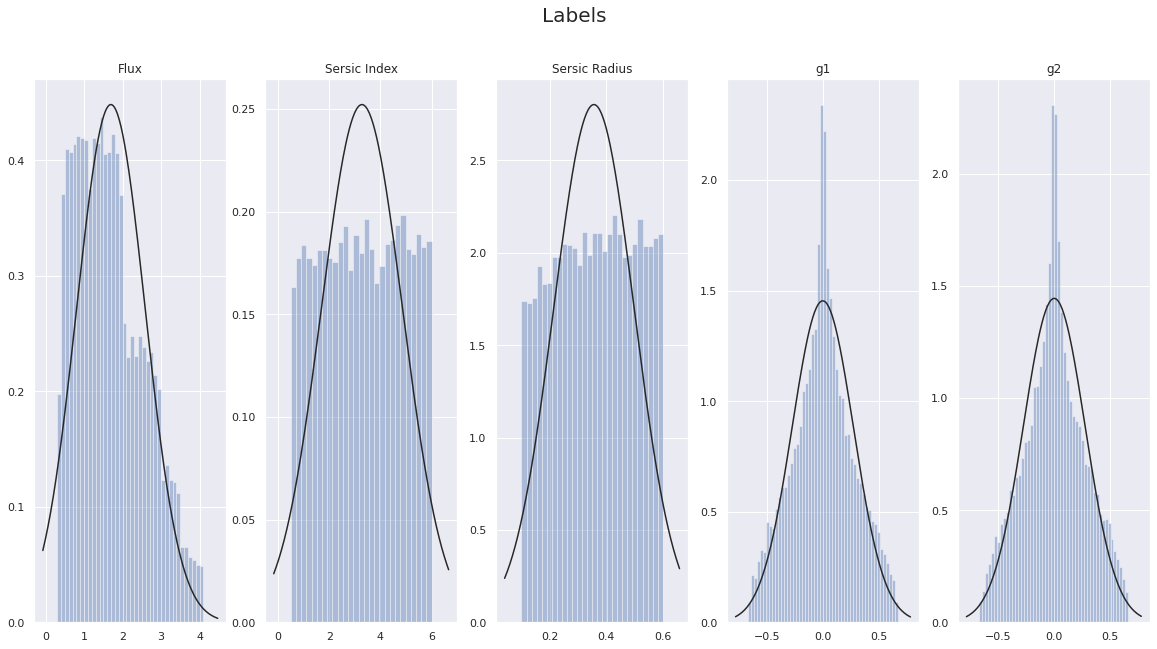

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels', fontsize=20)

sns.distplot(label[:, 0], fit=norm, kde=False,  ax=ax[0]).set_title('Flux')
sns.distplot(label[:, 1], fit=norm, kde=False,  ax=ax[1]).set_title('Sersic Index')
sns.distplot(label[:, 2], fit=norm, kde=False, ax=ax[2]).set_title('Sersic Radius')
sns.distplot(label[:, 3], fit=norm, kde=False, ax=ax[3]).set_title('g1')
sns.distplot(label[:, 4], fit=norm, kde=False, ax=ax[4]).set_title('g2')
plt.show()

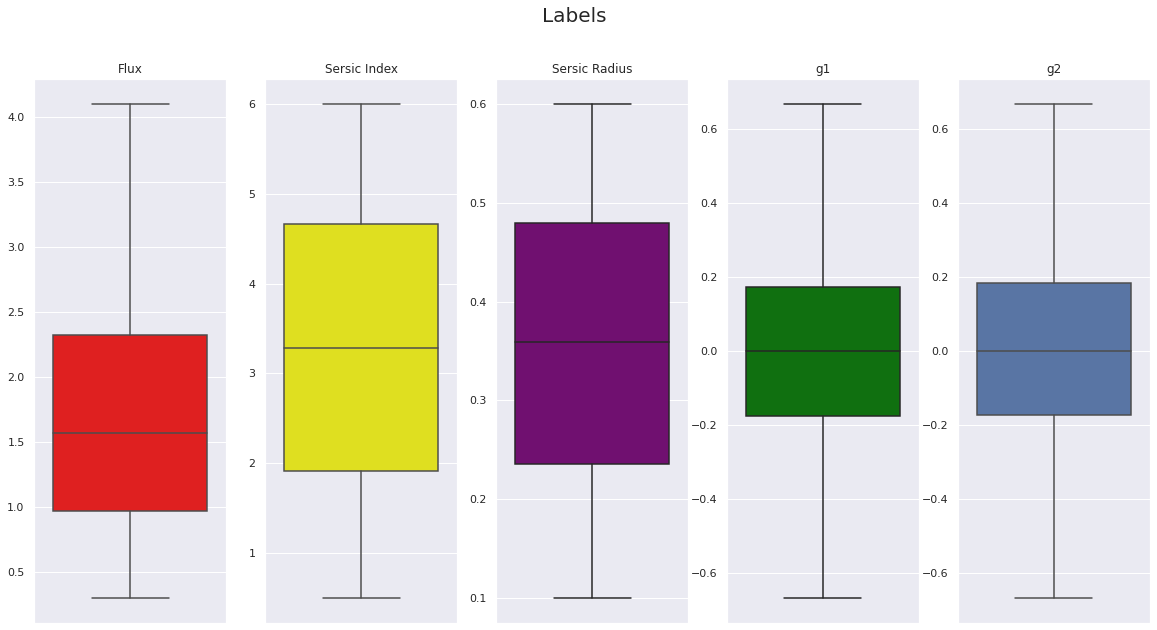

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels')

fig.suptitle('Labels', fontsize=20)
sns.boxplot(label[:, 0],  ax=ax[0], orient='v', color='red').set_title('Flux')
sns.boxplot(label[:, 1],  ax=ax[1], orient='v', color='yellow').set_title('Sersic Index')
sns.boxplot(label[:, 2],  ax=ax[2], orient='v', color='purple').set_title('Sersic Radius')
sns.boxplot(label[:, 3],  ax=ax[3],orient='v', color='green').set_title('g1')
sns.boxplot(label[:, 4],  ax=ax[4], orient='v').set_title('g2')
plt.show()


## **Inspecting Signal-to-Noise Ratio and Sigma**

Next, we plot the distribution of the signal to noise ratio of the galaxies. The code to simulate a galaxy removes all galaxies with ratios less than 10 or greater than 100, which is evident from the distribution.

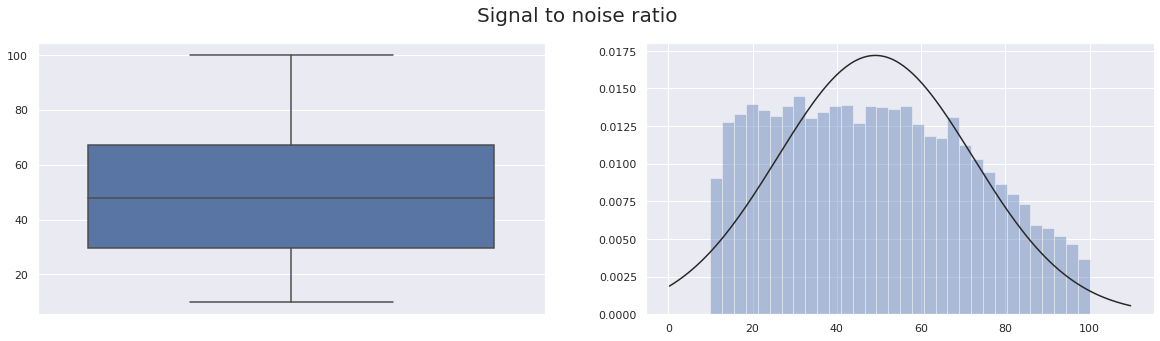

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Signal to noise ratio', fontsize=20);

sns.boxplot(snr, ax=ax[0], orient='v');
sns.distplot(snr, fit=norm, kde=False, ax=ax[1])
plt.show()


Below is the distribution for sigma, which was used to construct the noise map for each galaxy. As expected, sigma has a uniform distribution.

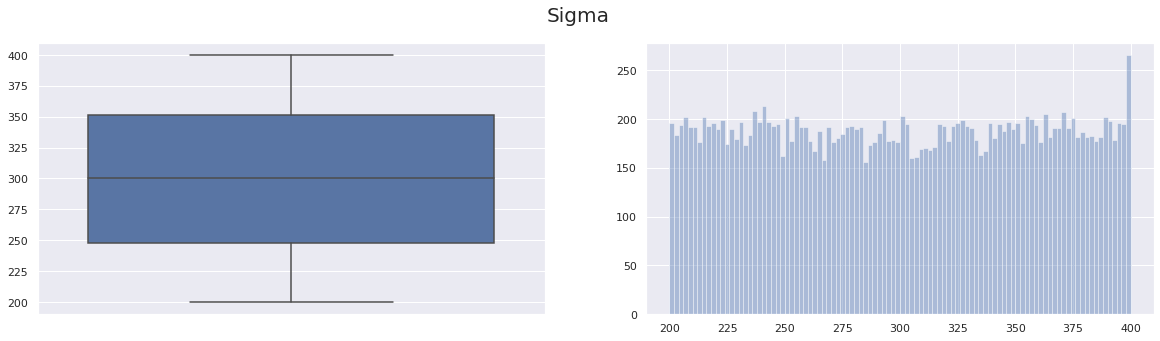

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Sigma', fontsize=20);

sns.boxplot(sigma, ax=ax[0], orient='v');
sns.distplot(sigma, kde=False, bins=100, ax=ax[1])
plt.show()

## **Key Questions**

**Given everything you have learned, if you faced this data set in the wild, how would you proceed?**

Unfortunately, "noiseless" images of galaxies like the ones we plotted above don't really exist -- signal noise is inherent to the process of taking pictures of objects millions of miles away! If we want to discern key information about the galaxies in our universe -- like flux or Sérsic index --  we must find a way to learn these parameters from the so-called "noisy" images.

We can use supervised learning to create a model that learns the essence of the data -- the actual galaxies. When fed an unfamiliar noisy image, a strong model will ignore the noise and output the galaxy's true parameters.

**What are the important measures?**

The parameters we seek to determine are flux, Sérsic index, Sérsic radius, g1, and g2. We are given images of galaxies that contain stochastic noise at every pixel, and we must train a model that essentially ignores this noise and uses only the actual galaxy to return the previously mentioned parameters.

**What are the right questions to ask, and how can the data answer them?**

We seek to learn the parameters of each galaxy, despite stochastic noise that makes this no easy task. So we ask, is it possible to accurately determine the parameters of a "noisy" galaxy? We can use a data set of noisy galaxies and their known parameters to train a model via supervised learning. Then we can simulate additional noisy galaxies and test our model's ability to accurately find their parameters. If the model performs well on the test set, we know that it has succeeded in ignoring irrelevant information. This finding has important repercussions for astronomers -- it may not be necessary to improve technology to reduce noise in images if we can glean all the information that we need from a noisy image.


## **Model Building and Performance Analysis**

**We have generated a new dataset for modeling. We created 1500 images from Galsim with flux, g1, g2 fixed and predicting only two parameters sersic index and sersic radius. We will use regression as a baseline model and then use various Convolutional Neural Networks**

In [0]:
#building a baseline model to compare against Deep Convolutional Neural Networks from our newly generated data
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [15]:
file_path = '/content/drive/My Drive/Data/Data_flux_radius'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive/Data/Data_flux_radius


In [0]:
image_no_noise3 = pd.read_pickle('img_no_noise2_flux_radius.pkl')
image_with_noise3 = pd.read_pickle('img_with_noise2_flux_radius.pkl')
labels3 = pd.read_pickle('labels2_flux_radius.pkl')
snr3 = pd.read_pickle('snr2_flux_radius.pkl')






In [0]:
print(f'Shape of image_no_noise: {image_no_noise3.shape}')
print(f'Shape of image_with_noise: {image_with_noise3.shape}')
print(f'Shape of labels: {labels3.shape}')

Shape of image_no_noise: (5000, 64, 64)
Shape of image_with_noise: (5000, 64, 64)
Shape of labels: (5000, 5)


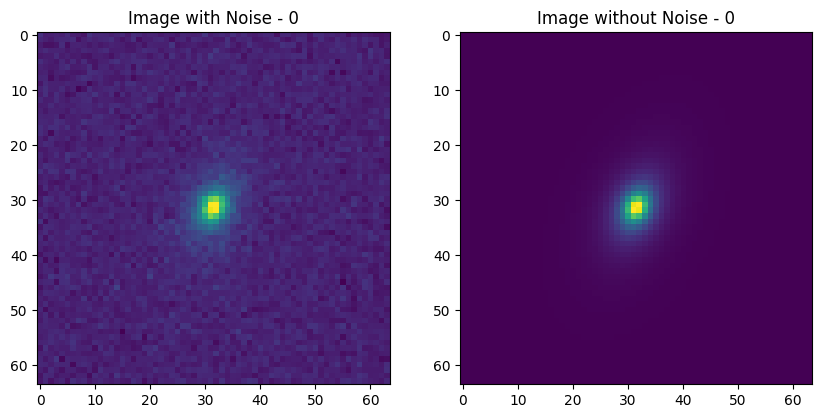

In [0]:
mpl.style.use('default')
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(image_with_noise3[0])
ax[1].imshow(image_no_noise3[0])
ax[0].set_title('Image with Noise - 0')
ax[1].set_title('Image without Noise - 0')
plt.show()

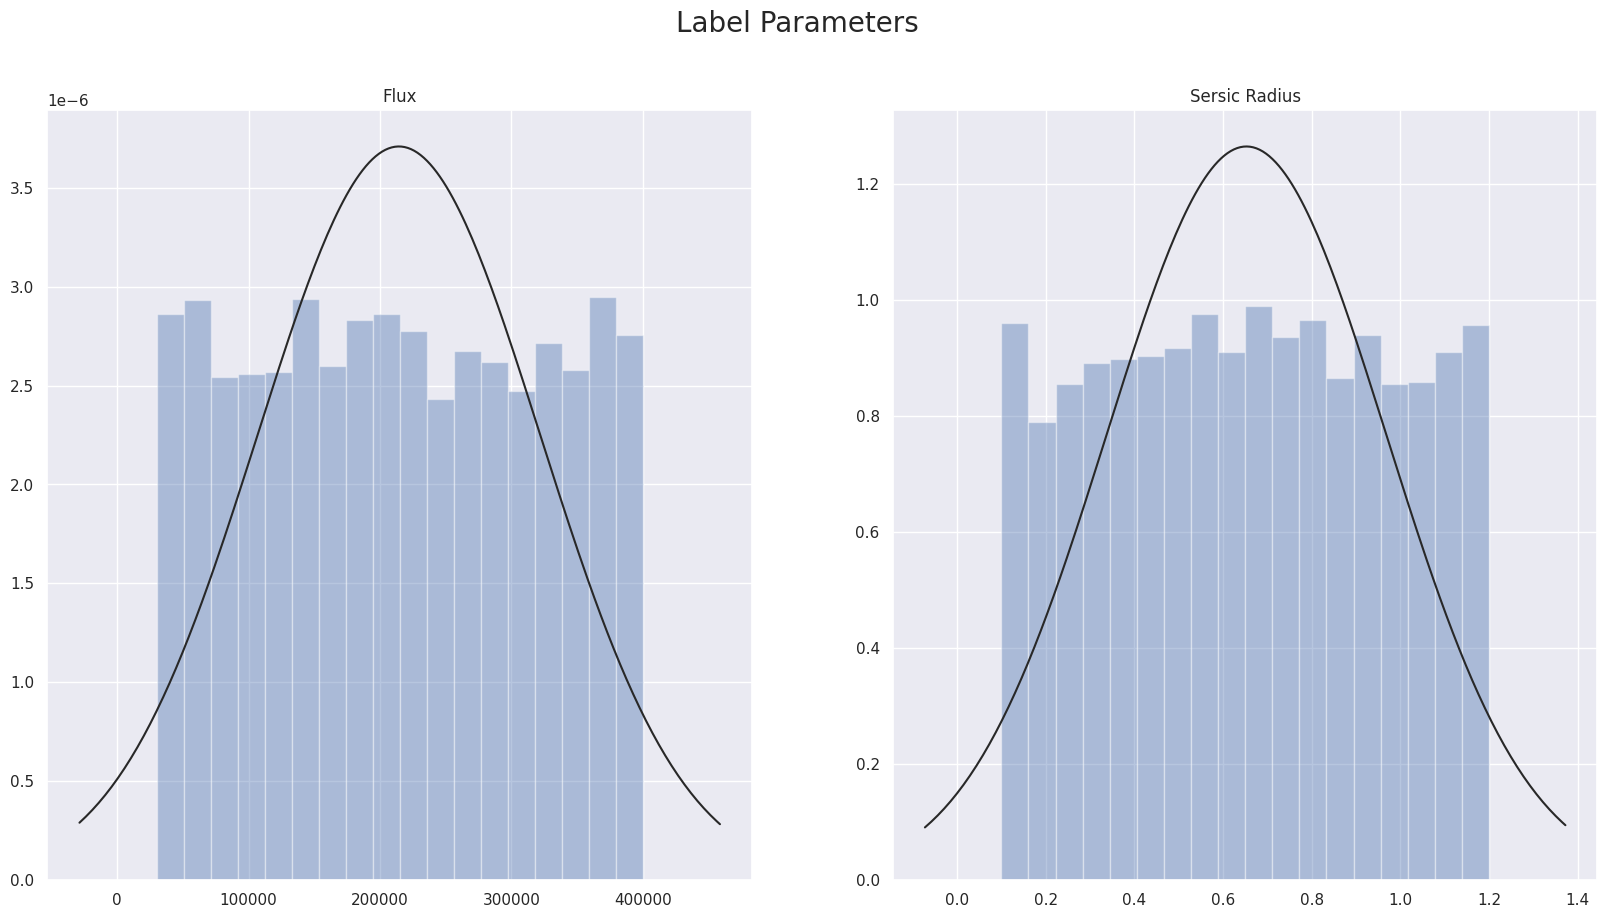

In [0]:
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('Label Parameter Distributions', fontsize=20)

sns.distplot(labels3[:, 0], fit=norm, kde=False,  ax=ax[0]).set_title('Flux')
sns.distplot(labels3[:, 2], fit=norm, kde=False,  ax=ax[1]).set_title('Sersic Radius')
plt.show()

In [0]:
#train test split
#regresssion model is doing better when the test size is bigger
#Once the dataset increases to 10k we should see better improvement
X_train, X_test, y_train, y_test = train_test_split(
 image_with_noise3, labels3, test_size=0.20,   random_state=109)

In [0]:
print(f'Shape of X_train {X_train.shape}')
print(f'Shape of X_test {X_test.shape}')
print(f'Shape of y_train {y_train.shape}')
print(f'Shape of y_test {y_test.shape}')

Shape of X_train (4000, 64, 64)
Shape of X_test (1000, 64, 64)
Shape of y_train (4000, 5)
Shape of y_test (1000, 5)


In [0]:
%%time
#Using RidgeCV Model with L2 penalty to fit X_train
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5).fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:, [0,2]])

CPU times: user 1min 12s, sys: 7.12 s, total: 1min 19s
Wall time: 41.3 s


In [0]:
print(f'Traning Score is: {clf.score(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:, [0,2]])*100:.2f}')
print(f'Testing Score is: {clf.score(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]), y_test[:, [0,2]])*100:.2f}')

Traning Score is: 100.00
Testing Score is: 89.31


In [0]:
y_pred = clf.predict(X_test.reshape(-1, X_test.shape[1]* X_test.shape[2]))

In [0]:
print(f' R2 Score is: {r2_score(y_test[:, [0,2]], y_pred)*100.0:2f}')

 R2 Score is: -445.737396


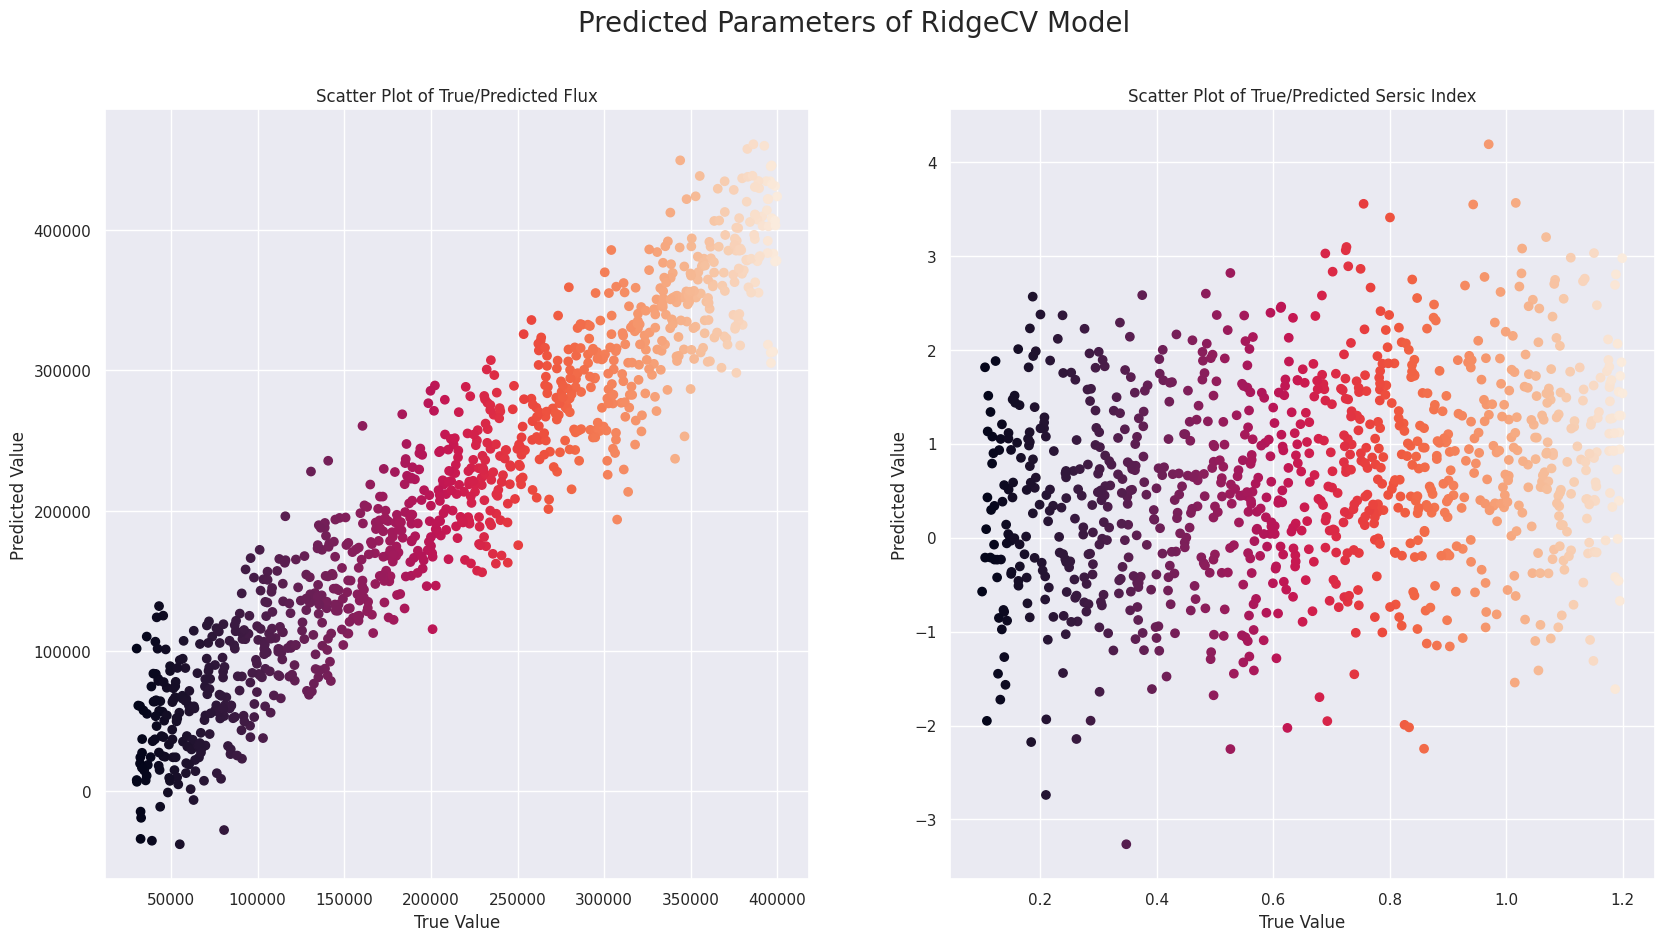

In [0]:
#plot predicted parameter distributions
# mpl.style.use('default')
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('Predicted Parameters of RidgeCV Model', fontsize=20)

x_ax = np.random.randint(0,len(y_test), size=(len(y_test),1))

ax[0].scatter(y_test[:, [0]], y_pred[:, [0]], c=[y_test[:, [0]]])
ax[0].set_title('Scatter Plot of True/Predicted Flux')
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')


ax[1].scatter(y_test[:, [2]], y_pred[:, [1]], c=[y_test[:, [2]]])
ax[1].set_title('Scatter Plot of True/Predicted Sersic Index')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')


plt.show();

### CNN (using generated data w/fixed noise and 3 labels held constant)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers, optimizers

In [0]:
# Split data into train and test sets

indices = np.linspace(0, 4999, 5000)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_with_noise3, labels3, indices, test_size=0.2)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [50]:
indices_test

array([2.400e+03, 3.356e+03, 1.170e+02, 9.250e+02, 4.329e+03, 4.339e+03,
       2.542e+03, 2.156e+03, 4.130e+02, 3.314e+03, 4.524e+03, 1.782e+03,
       3.550e+03, 1.509e+03, 2.905e+03, 2.773e+03, 3.907e+03, 3.745e+03,
       4.376e+03, 9.870e+02, 4.861e+03, 8.680e+02, 2.508e+03, 2.190e+02,
       4.685e+03, 4.700e+03, 1.479e+03, 1.478e+03, 2.176e+03, 2.451e+03,
       1.011e+03, 7.430e+02, 4.224e+03, 4.668e+03, 6.570e+02, 2.687e+03,
       2.549e+03, 5.980e+02, 4.154e+03, 4.944e+03, 2.043e+03, 3.324e+03,
       4.012e+03, 8.330e+02, 4.544e+03, 4.911e+03, 3.183e+03, 3.443e+03,
       1.108e+03, 1.800e+03, 4.771e+03, 4.529e+03, 3.428e+03, 1.206e+03,
       3.651e+03, 1.266e+03, 4.454e+03, 4.542e+03, 6.980e+02, 3.994e+03,
       4.304e+03, 2.950e+02, 2.275e+03, 2.930e+03, 3.345e+03, 3.260e+03,
       2.491e+03, 4.319e+03, 4.723e+03, 2.636e+03, 9.160e+02, 8.510e+02,
       2.889e+03, 3.600e+01, 4.758e+03, 3.344e+03, 4.347e+03, 3.867e+03,
       3.747e+03, 2.138e+03, 3.936e+03, 2.570e+02, 

In [0]:
# Normalize data
#xmax_train, xmin_train = X_train.max(), X_train.min()
#xmax_test, xmin_test = X_test.max(), X_test.min()
#X_train = (X_train - xmin_train)/(xmax_train - xmin_train)
#X_test = (X_test - xmin_test)/(xmax_test - xmin_test)

In [0]:
# Function to create CNN
def create_model(num_param=2): 
    
    # Input shape
    input_shape = (64, 64, 1)

    # Create sequential model
    model = Sequential(name='CNN Model') 


    # Create sequential model
    model = Sequential() 

    # # Add network layers
    # model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization(axis=1))
    # model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization(axis=1))
    # model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2))

    # model.add(Flatten())
    # model.add(Dense(128, activation='linear')) # I know a bunch of linear layers is pointless, but tanh and sigmoid make weird things happen
    # model.add(Dense(32, activation='linear'))
    # model.add(Dense(num_param, activation='linear'))

    model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu',  input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', strides = (2,2), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01),))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding = 'same', strides = (2,2), activation='relu', 
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', strides = (2,2), activation='relu', 
                    kernel_regularizer=regularizers.l2(0.01),))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(1, (3, 3), padding = 'same', strides = (2,2), activation='relu'))
    model.add(BatchNormalization())


    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),))
    model.add(Dense(num_param, activation='linear'))

    model.summary()
    
    return model

In [53]:
# Create model
CNN = create_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       36992     
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 512)      

In [0]:

#Create optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)


#create callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,
            verbose=1)]

# Compile model
CNN.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])


In [55]:
# Set hyperparameters
batch_size = 32
epochs = 50

# Train model
history = CNN.fit(X_train, y_train[:, [0,2]], batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test[:, [0,2]]), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - 7s 60ms/step - loss: 5.6712 - mean_absolute_error: 0.4082 - val_loss: 5.1361 - val_mean_absolute_error: 0.6538
Epoch 2/50
125/125 [==============================] - 7s 58ms/step - loss: 3.9036 - mean_absolute_error: 0.1287 - val_loss: 3.3783 - val_mean_absolute_error: 0.2599
Epoch 3/50
125/125 [==============================] - 7s 58ms/step - loss: 2.7148 - mean_absolute_error: 0.1172 - val_loss: 2.3533 - val_mean_absolute_error: 0.2247
Epoch 4/50
125/125 [==============================] - 7s 58ms/step - loss: 1.8846 - mean_absolute_error: 0.1103 - val_loss: 1.6781 - val_mean_absolute_error: 0.2156
Epoch 5/50
125/125 [==============================] - 7s 58ms/step - loss: 1.3295 - mean_absolute_error: 0.0971 - val_loss: 1.3510 - val_mean_absolute_error: 0.3191
Epoch 6/50
125/125 [==============================] - 7s 58ms/step - loss: 0.9908 - mean_absolute_error: 0.1027 - val_loss: 0.9780 - val_mean_absolute_error: 0.2161
Epoch 7/50

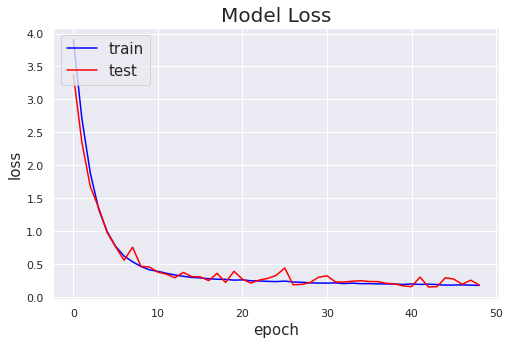

In [56]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

In [57]:
print('\n# Evaluate on test data')
results = CNN.evaluate(X_test, y_test[:, [0,2]], batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
8/8 [==============================] - 0s 48ms/step - loss: 0.1816 - mean_absolute_error: 0.0825
test loss, test acc: [0.18163970112800598, 0.08250052481889725]


In [0]:
# Generate predictions
CNN_predictions = CNN.predict(X_test)

In [0]:
indices_test = indices_test.astype(int)

Text(0, 0.5, 'Predicted Value')

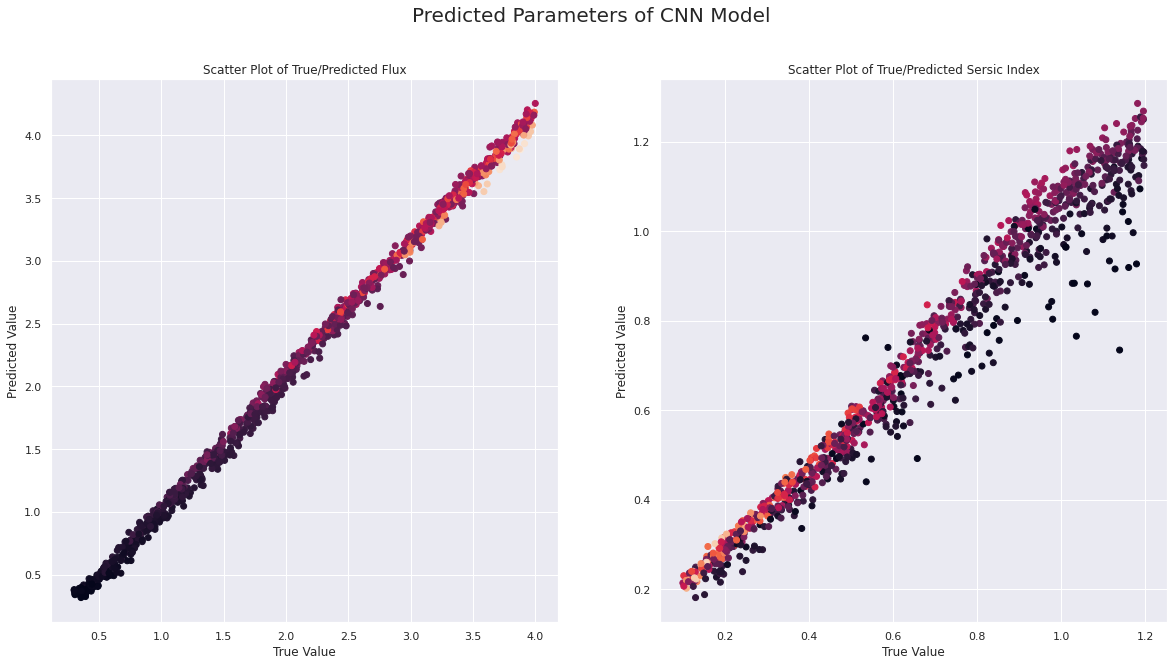

In [61]:
#plot the five predicted parameter distributions
#plot the five predicted parameter distributions
# mpl.style.use('default')
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('Predicted Parameters of CNN Model', fontsize=20)

# x_ax = np.random.randint(0,len(y_test), size=(len(y_test),1))

ax[0].scatter(y_test[:, [0]], CNN_predictions[:, 0], c=[snr3[indices_test]])
ax[0].set_title('Scatter Plot of True/Predicted Flux')
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')


ax[1].scatter(y_test[:, [2]], CNN_predictions[:, 1], c=[snr3[indices_test]])
ax[1].set_title('Scatter Plot of True/Predicted Sersic Index')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')

**Inference from Parametric Model**

Here we apply the traditional method of determining a galaxy profile (Sersic parameters): parametric modeling and Markov Chain Monte Carlo (MCMC). In essence, we first assign prior distributions to the 5 galaxy parameters. We then provide a parametric model (a function which maps Sersic profile to a galaxy image) and an input image. Finally, we apply MCMC to get the likely distribution of each galaxy parameter.

In [0]:
import pymc3 as pm
from tensorflow.keras.layers import Layer, Reshape, BatchNormalization, Input, Dense
from tensorflow.keras.initializers import Zeros
from sklearn.preprocessing import MinMaxScaler
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [0]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(image_with_noise3, labels3, test_size=0.2)

In [0]:
y_scaler = MinMaxScaler().fit(y_train)
y_train_norm = y_scaler.transform(y_train)
X_train_norm = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))

In [0]:
class Sampling(Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        # your code here
        batch = tf.keras.backend.shape(z_mean)[0]
        dim = tf.keras.backend.int_shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [0]:
input_shape = (5,)
n_pixels = 64 ** 2

# encoder 
inputs = Input(shape=input_shape, name='sersic_profile')
dense1 = Dense(64, activation='relu', name='dense1')(inputs)
dense2 = Dense(128, activation='relu', name='dense2')(dense1)
# dense3 = Dense(256, activation='relu', name='dense3')(dense2)
# dense4 = Dense(512, activation='relu', name='dense4')(dense3)
# dense5 = Dense(1024, activation='relu', name='dense5')(dense4)
# dense6 = Dense(2048, activation='relu', name='dense6')(dense5)

# mean and log-variance of each pixel
z_mean = Dense(n_pixels, activation='linear', name='mean')(dense2)
z_log_var = Dense(n_pixels, activation='linear', name='log_var')(dense2)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# decoder
pixels = Input(shape=(n_pixels,), name='z_sampling')
reshape = Reshape((64, 64))(pixels)
decoder = Model(pixels, reshape, name='decoder')
 
# auto-encoder
outputs = decoder(encoder(inputs)[2])
AE = Model(inputs, outputs, name='AE')

# compile and summary
AE.compile(optimizer='adam', loss='mse')

In [0]:

AE_history = AE.fit(y_train_norm, X_train_norm, batch_size=64, epochs=20, 
                    validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/20
50/50 [==============================] - 0s 7ms/step - loss: 0.6573 - val_loss: 0.1400
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0385 - val_loss: 0.0069
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 9.0710e-04 - val_loss: 5.5251e-04
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 5.1800e-04 - val_loss: 3.2469e-04
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 3.2743e-04 - val_loss: 2.2194e-04
Epoch 8/20
50/50 [==============================] - 0s 5ms/step - loss: 2.2813e-04 - val_loss: 1.5961e-04
Epoch 9/20
50/50 [==============================] - 0s 6ms/step - loss: 1.7105e-04 - val_loss: 1.2649e-04
Epoch 10/20
50/50 [==============================] - 0s 5ms/step - loss: 1.358

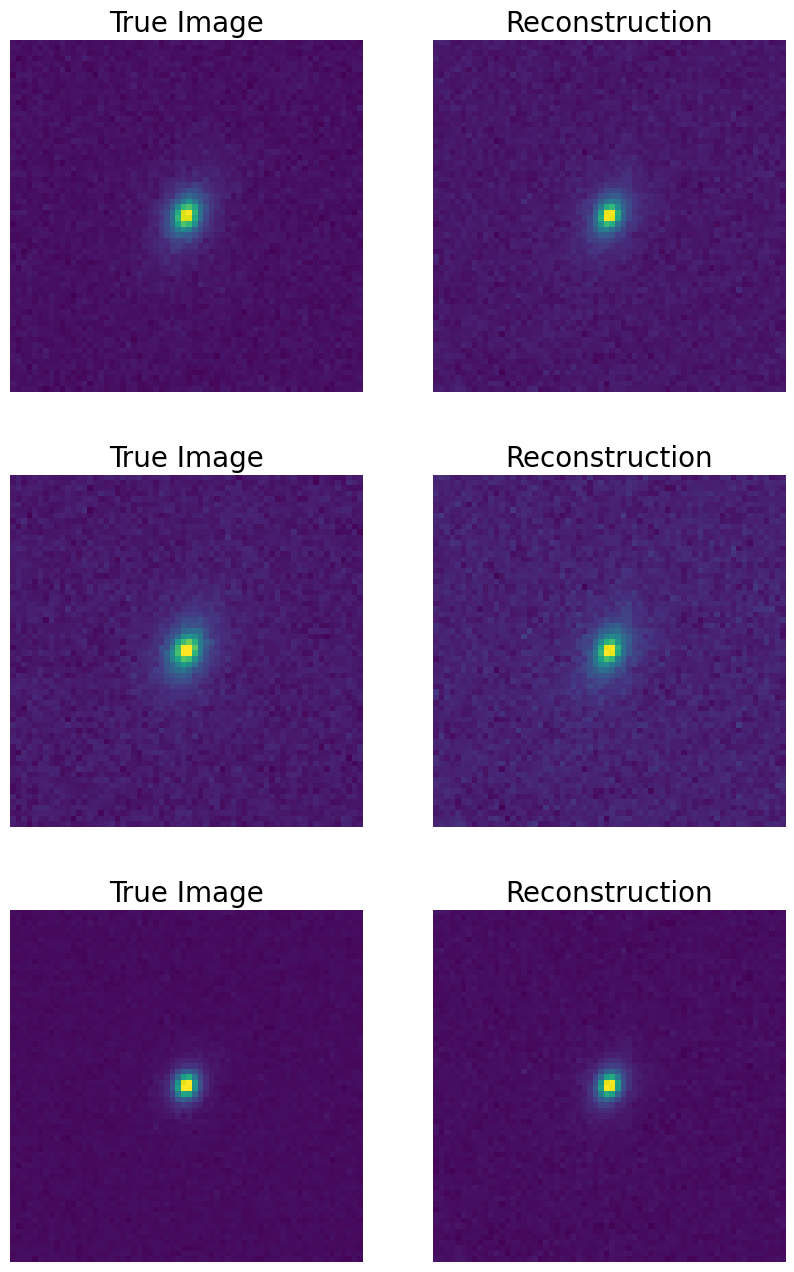

In [0]:

fig, ax = plt.subplots(3, 2, figsize=(10,16))
mpl.style.use('default')

# random images
image_indices = np.random.randint(low=0, high=y_train.shape[0]-1, size=3)

for i, indx in enumerate(image_indices):
  # true image
  ax[i][0].imshow(X_train_norm[indx].reshape(64, 64))
  ax[i][0].set_title('True Image' + str(), fontsize=20)
  ax[i][0].axis('off')
  ax[i][0].grid(False)

  # decoder prediction
  ax[i][1].imshow(AE.predict(y_train_norm[indx].reshape(1, 5))[0])
  ax[i][1].set_title('Reconstruction', fontsize=20)
  ax[i][1].axis('off')
  ax[i][1].grid(False)

In [0]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dscalar] * 5, otypes=[tt.dvector, tt.dmatrix])
def mean_covariance(flux, index, radius, g1, g2):

  # noise variance
  noise_var = 100
  noise_cov = np.diag(np.full(4096, noise_var))

  # Sersic profile
  profile = np.array([flux, index, radius, g1, g2]).reshape(1, 5)

  # mean and variance of each pixel
  mu, cov, _ = encoder.predict(profile)
  mu = mu[0]
  cov = np.diag(cov[0]) + noise_cov

  return mu.astype(np.float64), cov.astype(np.float64)

In [0]:

with pm.Model() as parametric_model:

  # Sersic profile
  flux = pm.Normal('flux', mu=0, sd=100)
  index = pm.Normal('sersic index', mu=0, sd=100)
  radius = pm.Normal('sersic radius', mu=0, sd=100)
  g1 = pm.Normal('g1', mu=0, sd=100)
  g2 = pm.Normal('g2', mu=0, sd=100)

  # parameters of pixels in image with noise included
  mu, cov = mean_covariance(flux, index, radius, g1, g2)

  # distribution of pixels in image with noise
  images = pm.MvNormal('pixels', mu=mu, cov=cov, shape=4096, observed=X_train_norm[0].flatten())

  # trace
  step = pm.Metropolis([flux, index, radius, g1, g2])
  trace = pm.sample(20, tune=10, step=step)

Only 20 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [g2]
>Metropolis: [g1]
>Metropolis: [sersic radius]
>Metropolis: [sersic index]
>Metropolis: [flux]
Sampling chain 1, 0 divergences: 100%|██████████| 30/30 [06:38<00:00, 13.27s/it]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


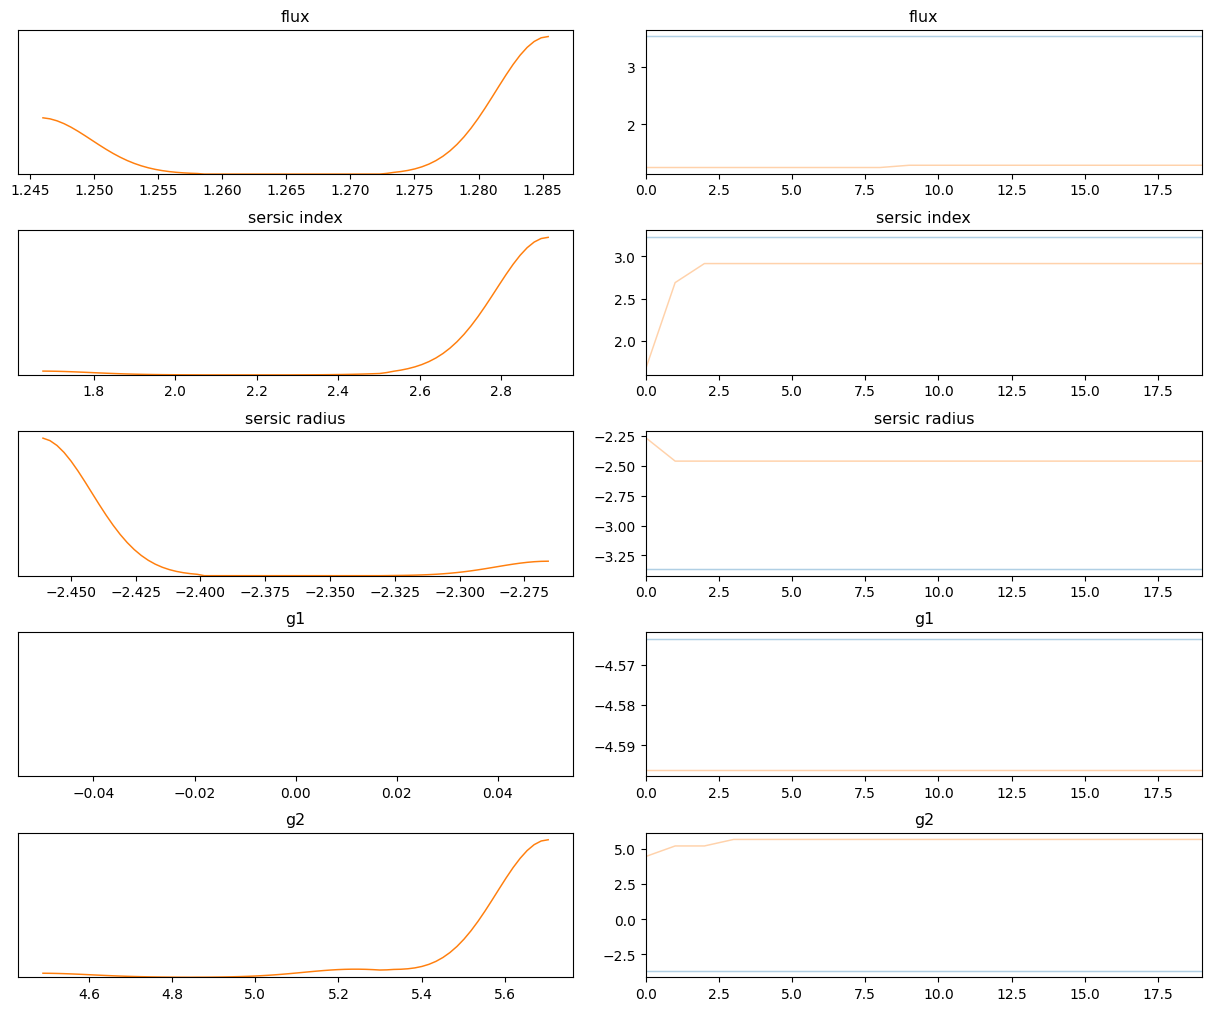

In [0]:

import arviz as az
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
az.plot_trace(trace);

In [0]:
y_train_norm[0]


array([0.62896395, 0.        , 0.61640938, 0.        , 0.        ])